<a href="https://colab.research.google.com/github/antussa2016/Data_mining/blob/master/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import wordcloud as WordCloud

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report, accuracy_score


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
fake = pd.read_csv("/content/drive/MyDrive/Fake.csv")

In [5]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [7]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

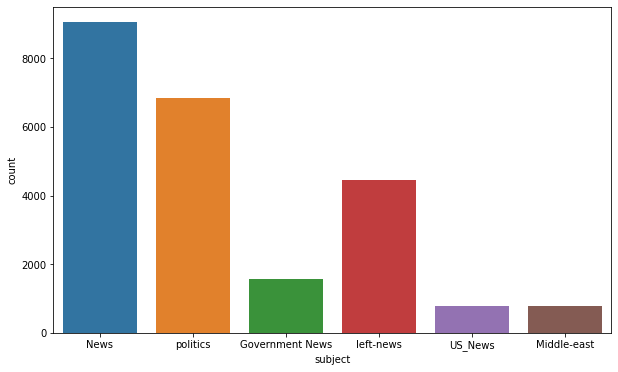

In [15]:
plt.figure(figsize=(10,6))
sns.countplot(x='subject', data=fake)

# **Wordcloud** 

In [ ]:
text=' '.join(fake['text'].tolist())
type(text)

In [ ]:
' '.join(['i','am','antu'])

In [43]:
wordCloud = WordCloud.WordCloud(width=1920,height=1000).generate(text)


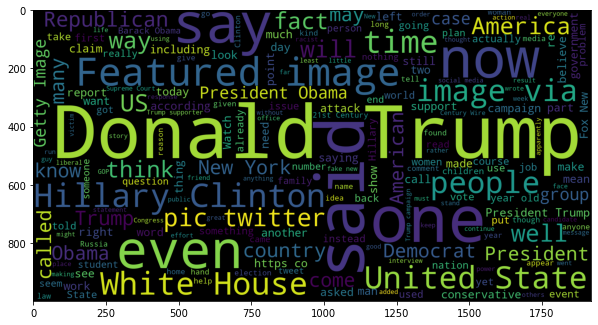

In [44]:
fig=plt.figure(figsize=(10,6))
plt.imshow(wordCloud)